# <center> <h1>Assignment 5</h1> </center>
<center> <h1>EIN 4933/6935 Python for Data Science Summer 2020</h1> </center>

Click the link below and download the file named "auto_mpg_modified.csv".<br/>
Link: https://sites.google.com/site/yasinunlu/home/research/new1/auto_mpg_modified.csv<br/>
You can find more info about the data set <a href="https://sites.google.com/site/yasinunlu/home/research/new1/auto_mpg_info.txt">here</a>. 

### Questions:
1) Read the file and create a dataframe and name it "df".<br/>
2) Perform the following data preprocessing:<br/>
a) Remove uncessary column(s) that cannot be used for training any models. Remove from df. Explain why you choose those column(s).<br/>
b) Determine any missing data point in df. Replace those missing data points with an imputated value. <br/>
c) Make sure columns labaled as "multi-valued discrete" are of integer type while "continuous" ones are of float type. You can read the column labels in this <a href="https://sites.google.com/site/yasinunlu/home/research/new1/auto_mpg_info.txt">file</a>. The final dataframe should be named "df_clean".<br/>
3) Prepare the following dataframes.<br/> 
a) Create a dataframe called "response" including only the column "mpg".<br/>
b) Create a dataframe called "features" with the remaining columns.<br/>
c) Prepare a dataframe named "features_train": random 80% rows of the dataframe "features"<br/>
d) Prepare a dataframe named "features_test": random 20% rows of the dataframe "features"<br/>
e) Prepare a dataframe named "response_train": random 80% rows of the dataframe "response"<br/>
f) Prepare a dataframe named "response_test": random 20% rows of the dataframe "response"<br/>
4) Create a multiple linear regressoin model from scikit learn package. Train your model using the train data that you created above. <br/>
5) Produce predictions over the test data.<br/>
6) Evaluate the model performance over the test data by tabulating metrics of Mean Absolute Error, Mean Squared Error and Root Mean Squared Error.<br/>
7) Normalize the data stored in df_clean. <br/>
8) Fit a multiple linear regression model using the normalized data.<br/>
9) Extract Feature Importance. That is, repor the coefficients (i.e. estimated parameters) of the fit model.<br/>
10) Summarize results with a bar chart.<br/>

In [1]:
import pandas as pd

# 1) Read the file and create a dataframe and name it "df".

In [2]:
df = pd.read_csv("auto_mpg_modified.csv")
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8.0,307.0,130.0,3504,12.0,70,1.0,chevrolet chevelle malibu
1,15.0,8.0,350.0,165.0,3693,11.5,70,1.0,buick skylark 320
2,18.0,8.0,318.0,150.0,3436,11.0,70,1.0,plymouth satellite
3,16.0,8.0,304.0,150.0,3433,12.0,70,1.0,amc rebel sst
4,17.0,8.0,302.0,140.0,3449,10.5,70,1.0,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4.0,140.0,86.0,2790,15.6,82,1.0,ford mustang gl
394,44.0,4.0,97.0,52.0,2130,24.6,82,2.0,vw pickup
395,32.0,4.0,135.0,84.0,2295,11.6,82,1.0,dodge rampage
396,28.0,4.0,120.0,79.0,2625,18.6,82,1.0,ford ranger


# 2) Perform the following data preprocessing: 

In [3]:
# The final dataframe should be named "df_clean".
df_clean = df.copy()

# b) Determine any missing data point in df. Replace those missing data points with an imputated value.
df_clean.isna().any()

mpg             False
cylinders        True
displacement    False
horsepower       True
weight          False
acceleration    False
year            False
origin           True
name            False
dtype: bool

In [4]:
cyl_na_idx = df_clean[df_clean.cylinders.isna()].index  # create index to verify later
hp_na_idx = df_clean[df_clean.horsepower.isna()].index  # create index to verify later
origin_na_idx = df_clean[df_clean.origin.isna()].index  # create index to verify later

***

## Impute cylinders by displacement
Since none of the missing valuse have displacements within the overlapping ranges between cylinders, I will impute cylinders based on the standard ranges for displacement. There are no missing values in the 4 cylinder range so I don't have to worry about those.

In [5]:
print("4 cyl max:", df_clean.loc[df_clean['cylinders']==4.0, 'displacement'].max(),"\n")
print("6 cyl min:", df_clean.loc[df_clean['cylinders']==6.0, 'displacement'].min())
print("6 cyl max:", df_clean.loc[df_clean['cylinders']==6.0, 'displacement'].max(), "\n")
print("8 cyl min:", df_clean.loc[df_clean['cylinders']==8.0, 'displacement'].min())

df_clean.loc[cyl_na_idx, ['cylinders', "displacement"]]

4 cyl max: 156.0 

6 cyl min: 145.0
6 cyl max: 262.0 

8 cyl min: 260.0


,cylinders,displacement
43,NaN,400.0
67,NaN,429.0
106,NaN,350.0
125,NaN,198.0


In [6]:
# set NaN values for displacement greater than 262 for 8 cylinders
df_clean.loc[(df_clean['displacement']>262) & (df_clean['cylinders'].isna()), 'cylinders'] = 8.0

# set NaN values for displacement less than 262 for 6 cylinders
df_clean.loc[(df_clean['displacement']<262) & (df_clean['cylinders'].isna()), 'cylinders'] = 6.0

df_clean.loc[cyl_na_idx,['cylinders', "displacement"]]

,cylinders,displacement
43,8.0,400.0
67,8.0,429.0
106,8.0,350.0
125,6.0,198.0


***

## Impute horsepower by cylinders

Since horsepower probably depends on the number of cylinders in the engine and the displacement, we should **not** impute horsepower with just the mean of the *entire column*. 

For simplicity I will replace the horsepower for 6 cylinder engines with the average horsepower for that group and then do the same for 4 cylinder engines.

In [7]:
# calculate the mean values
mean_4cyl = round(df_clean.loc[df_clean['cylinders']==4.0, 'horsepower'].mean())
mean_6cyl = round(df_clean.loc[df_clean['cylinders']==6.0, 'horsepower'].mean())

# set NaN values for horsepower of 6 cylinder engines to the mean hp for 6 cylinders
df_clean.loc[(df_clean['cylinders']==6.0) & (df_clean['horsepower'].isna()), 'horsepower'] = mean_6cyl

# set NaN values for horsepower of 4 cylinder engines to the mean hp for 4 cylinders
df_clean.loc[(df_clean['cylinders']==4.0) & (df_clean['horsepower'].isna()), 'horsepower'] = mean_4cyl

df_clean.loc[hp_na_idx, ['cylinders', 'horsepower']]

,cylinders,horsepower
32,4.0,78.0
126,6.0,102.0
330,4.0,78.0
336,4.0,78.0
354,4.0,78.0
374,4.0,78.0


***


## Impute Origin by origin of other vehicles with the same make

Since, in this data set, all other vehicles by the same *make* (i.e "dodge") are from the same origin, I will replace `NaN` values in 'origin' column with the mean value from other cars of the same make (since all othe origins for a make are all the same, taking the mean will give me that value).

In [8]:
vehicle_makes = ["chevrolet","volkswagen","dodge","renault","peugeot","chrysler"]

for make in vehicle_makes:
    mean = df_clean.loc[df_clean['name'].str.contains(make), 'origin'].mean()   # find the mean
    # replace origin NaN for that make with its mean 
    df_clean.loc[(df_clean['name'].str.contains(make)) & (df_clean['origin'].isna()), 'origin'] = mean  

df_clean.loc[origin_na_idx, ['origin', 'name']]

,origin,name
6,1.0,chevrolet impala
77,2.0,volkswagen 411 (sw)
146,1.0,dodge colt
218,2.0,renault 5 gtl
299,2.0,peugeot 504
353,2.0,volkswagen jetta
388,1.0,chrysler lebaron medallion


In [9]:
# make sure no more missing values in df
df_clean.isna().any()  

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
year            False
origin          False
name            False
dtype: bool

## Remove `name` column `cylinders`, and `horespower`

Since the name column is all (mostly) unique values of type string it won't add any predictive ability so I will remove it. For now, I will let all other columns remain.

In [10]:
# a) Remove uncessary column(s) that cannot be used for training any models. Explain why you choose those column(s).
df_clean.drop(["name","cylinders","horsepower"], axis=1, inplace=True)


# c) Make sure columns labaled as "multi-valued discrete" are of integer type while "continuous" ones are of float type.
# df_clean['cylinders'] = df_clean['cylinders'].astype(int)
df_clean['year'] = df_clean['year'].astype(int) # drop from df?
df_clean['origin'] = df_clean['origin'].astype(int)

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   displacement  398 non-null    float64
 2   weight        398 non-null    int64  
 3   acceleration  398 non-null    float64
 4   year          398 non-null    int32  
 5   origin        398 non-null    int32  
dtypes: float64(3), int32(2), int64(1)
memory usage: 15.7 KB


# 3) Prepare the following dataframes.

In [11]:
print(df_clean.shape)
df_clean.head()

(398, 6)


,mpg,displacement,weight,acceleration,year,origin
0,18.0,307.0,3504,12.0,70,1
1,15.0,350.0,3693,11.5,70,1
2,18.0,318.0,3436,11.0,70,1
3,16.0,304.0,3433,12.0,70,1
4,17.0,302.0,3449,10.5,70,1


In [12]:
from sklearn.model_selection import train_test_split

# a) Create a dataframe called "response" including only the column "mpg".
response = df_clean[['mpg']]

# b) Create a dataframe called "features" with the remaining columns.
features = df_clean.iloc[:,1:]


In [13]:
# c) Prepare a dataframe named "features_train": random 80% rows of the dataframe "features"
# d) Prepare a dataframe named "features_test": random 20% rows of the dataframe "features"
# e) Prepare a dataframe named "response_train": random 80% rows of the dataframe "response"
# f) Prepare a dataframe named "response_test": random 20% rows of the dataframe "response"

result_list = train_test_split(features, response, test_size=0.2, random_state=64)

features_train, features_test, response_train, response_test = result_list

print("full df_clean:", df_clean.shape)
print("features_train:", features_train.shape)
print("features_test:", features_test.shape)
print("response_train:", response_train.shape)
print("response_test:", response_test.shape)

full df_clean: (398, 6)
features_train: (318, 5)
features_test: (80, 5)
response_train: (318, 1)
response_test: (80, 1)


# 4) Create a multiple linear regressoin model from scikit learn package. 
Train the model using the train data created above.

In [14]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(features_train, response_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# 5) Produce predictions over the test data.

In [15]:
response_pred = mlr.predict(features_test)

# 6) Evaluate the model performance over the test data by tabulating metrics of Mean Absolute Error, Mean Squared Error and Root Mean Squared Error.

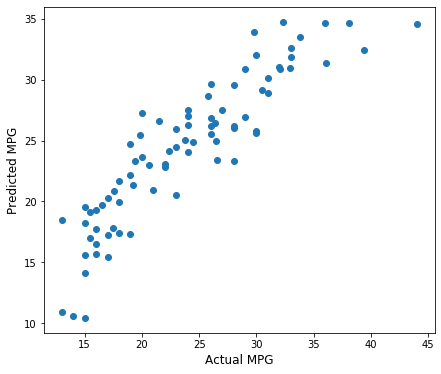

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 6))
plt.scatter(response_test, response_pred)
plt.ylabel('Predicted MPG', size = 12)
plt.xlabel('Actual MPG', size = 12)
plt.show()

In [17]:
import numpy as np
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(response_test, response_pred))
print('Mean Squared Error:', metrics.mean_squared_error(response_test, response_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(response_test, response_pred)))

Mean Absolute Error: 2.4539758289238955
Mean Squared Error: 9.413697106648476
Root Mean Squared Error: 3.068174882018376


# 7) Normalize the data stored in df_clean.

In [18]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_normalized = scaler.fit_transform(df_clean)
df_normalized = pd.DataFrame(data_normalized, columns = df_clean.columns.to_list())

df_normalized.head()

,mpg,displacement,weight,acceleration,year,origin
0,0.239362,0.617571,0.536150,0.238095,0.0,0.0
1,0.159574,0.728682,0.589736,0.208333,0.0,0.0
2,0.239362,0.645995,0.516870,0.178571,0.0,0.0
3,0.186170,0.609819,0.516019,0.238095,0.0,0.0
4,0.212766,0.604651,0.520556,0.148810,0.0,0.0


# 8) Fit a multiple linear regression model using the normalized data.

In [19]:
from sklearn.linear_model import LinearRegression
mlr_norm = LinearRegression()
features_norm = df_normalized.iloc[:,1:]
response_norm = df_normalized[['mpg']]
mlr_norm.fit(features_norm, response_norm) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# 9) Extract Feature Importance. 

Report the coefficients (i.e. estimated parameters) of the fit model.

In [20]:
importance = mlr_norm.coef_[0]      # list of estimated coeff parameters 
feature_names = df_normalized.columns.to_list()
feature_names.remove('mpg')
# summarize feature importance
for i, score in enumerate(importance):
    print('%s: %.5f' % (feature_names[i], score))

displacement: 0.11624
weight: -0.65727
acceleration: 0.06649
year: 0.24438
origin: 0.07148


In [21]:
importance = mlr_norm.coef_[0]      # list of estimated coeff parameters 
feature_names = df_normalized.columns.to_list()
feature_names.remove('mpg')
# summarize feature importance
for i, score in enumerate(importance):
    print('%s: %.5f' % (feature_names[i], score))

displacement: 0.11624
weight: -0.65727
acceleration: 0.06649
year: 0.24438
origin: 0.07148


## 10) Summarize results with a bar chart.

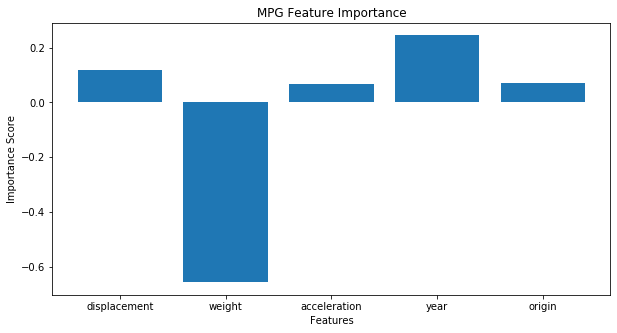

In [22]:
from matplotlib import pyplot
pyplot.figure(figsize=(10, 5))
# plot feature importance
pyplot.bar(x = list(range(len(importance))), height = importance, tick_label = feature_names)
pyplot.title('MPG Feature Importance')
pyplot.xlabel('Features')
pyplot.ylabel('Importance Score')
pyplot.show()

### Bonus Questions:
11) Analyze the results from the bar chart. Drop one or two least important features from df_clean.<br/>
12) Repeat Questions 3 - 6 and report the updated metrics of Mean Absolute Error, Mean Squared Error and Root Mean Squared Error. Compare the updated metric results agains the previous ones. 

In [ ]:
#work on your code here and after.

In [23]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# diabetes = datasets.load_diabetes()
X = features_norm #diabetes.data
y = response_norm #diabetes.target

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     356.9
Date:                Thu, 02 Jul 2020   Prob (F-statistic):          1.88e-143
Time:                        23:42:26   Log-Likelihood:                 402.08
No. Observations:                 398   AIC:                            -792.2
Df Residuals:                     392   BIC:                            -768.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4285      0.024     17.737   